# **CSE 7324 Lab 3: Extending Logistic Regression**
### *Thomas Adams, Suleiman Hijazeen, Nancy Le and Andrew Whigham*
------

### **1. Preparation and Overview**
------

#### 1.1 Business Understanding
---

Austin Animal Center is the largest no-kill shelter in the United States and provides shelter to more than 16,000 animals each year. As a no-kill shelter they refuse to euthanize any animal unless the animal has a terminal medical issue and is in pain or if the animal is a danger to the public or to the shelter staff. Although the shelter’s primary goal is to find ‘forever homes’ for each and every animal that comes through their doors, many animals end up staying in the shelter for a long time if they are not considered as desirable for adoption as other animals. In addition to adopting out animals, the Austin Animal Center partners with various other rescues and animal sanctuaries to try to find homes for their animals. 

The average annual cost per animal at the Austin Animal Center is approximately $715 [3] and with many animals staying at the facility for long periods of time, some for several years, the cost can add up quickly. The shelter has fixed financial support via legislation to cover costs for staffing the shelters and a few grants to cover veterinary staff and services, but the shelter primarily relies on donations to provide for food, bedding and toys for the animals. The shelter must try to minimize costs associated with each animal and try to have the animals leave the shelter through adoption or transfer to a sanctuary as quickly as possible.

The Austin Animal Center keeps track of each animal that comes through their doors and keeps a record of the animal’s outcome; that is whether they were adopted, transferred to a partner shelter or sanctuary or one of many other outcomes. If the shelter could predict an animal’s outcome based on the animal’s characteristics, they could be much more efficient with having animals leave the shelter by knowing which animals they should be able to adopt out and which animals they should transfer to other shelters or sanctuaries. This added efficiency would result in the shelter’s ability to take in more animals which in return would lower the average cost per animal.

This lab examines the Austin Animal Center animal outcome data set to specifically look at cats and the outcome of each cat and attempts to build an accurate model of predicting the outcome. If accurate, this model could serve the Austin Animal Center as well as other cities that are looking at issuing a no-kill ordinance for their shelters.

#### 1.2 Data Preparation
---

In [51]:
# dependencies
import pandas as pd
import numpy as np
import missingno as msno 
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split

from textwrap import wrap
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
import math
%matplotlib inline

In [52]:
# import data
shelter_outcomes = pd.read_csv("C:/Users/w47518657u/OneDrive/SMU Spring 2019/CSE 7318/Labs/Lab Three/aac_shelter_outcomes.csv")
# filter animal type for just cats
cats = shelter_outcomes[shelter_outcomes['animal_type'] == 'Cat']
#print(cats.head())

# remove age_upon_outcome and recalculate to standard units (days)
age = cats.loc[:,['datetime', 'date_of_birth']]
# convert to datetime
age.loc[:,'datetime'] = pd.to_datetime(age['datetime'])
age.loc[:,'date_of_birth'] = pd.to_datetime(age['date_of_birth'])
# calculate cat age in days
cats.loc[:,'age'] = (age.loc[:,'datetime'] - age.loc[:,'date_of_birth']).dt.days
# get dob info
cats['dob_month'] = age.loc[:, 'date_of_birth'].dt.month
cats['dob_day'] = age.loc[:, 'date_of_birth'].dt.day
cats['dob_dayofweek'] = age.loc[:, 'date_of_birth'].dt.dayofweek
# get month from datetime
cats['month'] = age.loc[:,'datetime'].dt.month
# get day of month
cats['day'] = age.loc[:,'datetime'].dt.day
# get day of week
cats['dayofweek'] = age.loc[:, 'datetime'].dt.dayofweek
# get hour of day
cats['hour'] = age.loc[:, 'datetime'].dt.hour
# get quarter
cats['quarter'] = age.loc[:, 'datetime'].dt.quarter

# clean up breed attribute
# get breed attribute for processing
# convert to lowercase, remove mix and strip whitespace
# remove space in 'medium hair' to match 'longhair' and 'shorthair'
# split on either space or '/'
breed = cats.loc[:, 'breed'].str.lower().str.replace('mix', '').str.replace('medium hair', 'mediumhair').str.strip().str.split('/', expand=True)
cats['breed'] = breed[0]
cats['breed1'] = breed[1]

# clean up color attribute
# convert to lowercase
# strip spaces
# split on '/'
color = cats.loc[:, 'color'].str.lower().str.strip().str.split('/', expand=True)
cats['color'] = color[0]
cats['color1'] = color[1]

# clean up sex_upon_outcome
sex = cats['sex_upon_outcome'].str.lower().str.strip().str.split(' ', expand=True)
sex[0].replace('spayed', True, inplace=True)
sex[0].replace('neutered', True, inplace=True)
sex[0].replace('intact', False, inplace=True)
sex[1].replace(np.nan, 'unknown', inplace=True)
cats['spayed_neutered'] = sex[0]
cats['sex'] = sex[1]

# add in domesticated attribute
cats['domestic'] = np.where(cats['breed'].str.contains('domestic'), 1, 0)

# combine outcome and outcome subtype into a single attribute
cats['outcome_subtype'] = cats['outcome_subtype'].str.lower().str.replace(' ', '-').fillna('unknown')
cats['outcome_type'] = cats['outcome_type'].str.lower().str.replace(' ', '-').fillna('unknown')
cats['outcome'] = cats['outcome_type'] + '_' + cats['outcome_subtype']

# drop unnecessary columns
cats.drop(columns=['animal_id', 'name', 'animal_type', 'age_upon_outcome', 'date_of_birth', 'datetime', 'monthyear', 'sex_upon_outcome', 'outcome_subtype', 'outcome_type'], inplace=True)
#print(cats['outcome'].value_counts())

cats.head()


,breed,color,age,dob_month,dob_day,dob_dayofweek,month,day,dayofweek,hour,quarter,breed1,color1,spayed_neutered,sex,domestic,outcome
0,domestic shorthair,orange tabby,15,7,7,0,7,22,1,16,3,None,None,False,male,1,transfer_partner
8,domestic shorthair,blue tabby,59,6,16,0,8,14,3,18,3,None,white,False,female,1,adoption_unknown
9,domestic shorthair,white,95,3,26,2,6,29,6,17,2,None,black,True,female,1,adoption_offsite
10,domestic mediumhair,black,366,3,27,2,3,28,4,14,1,None,white,True,female,1,return-to-owner_unknown
17,domestic shorthair,black,24,12,16,0,1,9,3,19,1,None,white,False,male,1,transfer_partner


Not all information included in this data set is necessary to the targeted prediction of outcome type. Some animals that were adopted were returned to the shelter as runaways before being returned to their owners. These instances have no impact on trying to predict outcome and will be removed from the data set.

#### 1.3 Data Description
---

In [53]:
print("Default datatypes of shelter cat outcomes:\n")
print(cats.dtypes)

print("\nBelow is a description of the attributes in the cats dataframe:\n")

Default datatypes of shelter cat outcomes:

breed              object
color              object
age                 int64
dob_month           int64
dob_day             int64
dob_dayofweek       int64
month               int64
day                 int64
dayofweek           int64
hour                int64
quarter             int64
breed1             object
color1             object
spayed_neutered    object
sex                object
domestic            int32
outcome            object
dtype: object

Below is a description of the attributes in the cats dataframe:



Attribute | Description | Scale | Datatype
--- | --- | --- | ---
Breed | Primary breed of the cat | Nominal | Object
Color | Primary color of the cat | Nominal | Object
Age | Age of cat in days | Ordinal | int64
DOB_Month | Date of birth month (1-12) for the cat  | Ordinal | int64
DOB_Day | Date of birth day (1-31) for the cat  | Ordinal | int64
DOB_DayOfWeek | Date of birth day of week (1-7) for the cat  | Ordinal | int64
Month | Month (1-12) of the outcome  | Ordinal | int64
Day | Day of month (1-31) of the outcome  | Ordinal | int64
DayOfWeek | Day of week (1-7) of the outcome  | Ordinal | int64
Hour | Hour during the day (0-23) of the outcome  | Ordinal | int64
Quarter | Quarter during the year (1-4) of the outcome  | Ordinal | int64
Breed1 | Secondary breed of the cat  | Nominal | Object
Color1 | Secondary color of the cat  | Nominal | Object
Spayed_Neutered | Is the cat spayed/netured or not  | Nominal | bool
Sex | Sex of the cat  | Nominal | bool
Domestic | Is the cat domesticated  | Nominal | bool
Outcome | The outcome of the animal  | nominal | object

In [54]:
print('Below is a listing of the target classes and their distributions:')
cats['outcome'].value_counts()

Below is a listing of the target classes and their distributions:


transfer_partner           9486
adoption_unknown           9264
adoption_foster            3357
transfer_scrp              3211
return-to-owner_unknown    1431
euthanasia_suffering       1304
transfer_snr                625
died_in-kennel              208
died_in-foster              138
adoption_offsite            110
euthanasia_rabies-risk       61
euthanasia_medical           56
rto-adopt_unknown            33
died_unknown                 17
died_at-vet                  17
disposal_unknown             16
euthanasia_at-vet            16
died_enroute                 15
missing_in-foster            14
euthanasia_unknown           11
died_in-surgery               8
missing_in-kennel             7
missing_unknown               5
euthanasia_aggressive         4
unknown_unknown               3
missing_possible-theft        2
euthanasia_underage           1
transfer_barn                 1
adoption_barn                 1
Name: outcome, dtype: int64

Each feature has a different count, a low count per feature decrease the accuracy and the efficiency of the logistic regression method used, so all features with low count was not taken into account in traning the classfier

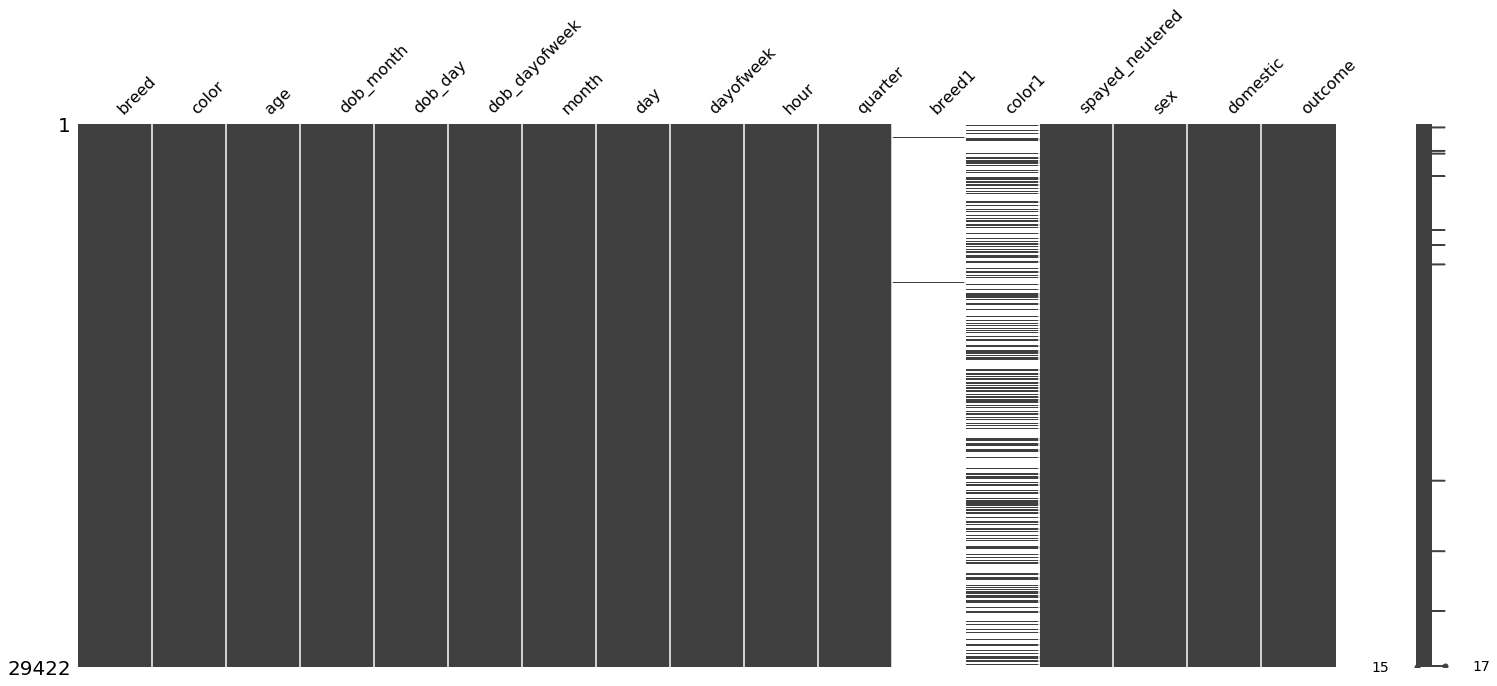

In [55]:
# examine missing data
msno.matrix(cats)

Since the missing data shows that breed1 will have little impact on the prediction since there are only two records that have a value, it will be removed from the data set. The missing data in color1 should be handled when one hot encoding is performed on it.

#### 1.4 One hot encoding of data and splitting into training and testing sets

In [56]:
cats.drop(columns=['breed1'], inplace=True)
# Breed, Color, Color1, Spayed_Netured and Sex attributes need to be one hot encoded
cats_ohe = pd.get_dummies(cats, columns=['breed', 'color', 'color1', 'spayed_neutered', 'sex'])
cats_ohe.head()
out_t={'euthanasia_suffering' : 0, 'died_in-kennel' : 0, 'return-to-owner_unknown' : 0, 'transfer_partner' : 1, 'euthanasia_at-vet' : 2, 'adoption_foster' : 3, 'died_in-foster' : 0, 'transfer_scrp' : 4, 'euthanasia_medical' : 0, 'transfer_snr' : 0, 'died_enroute' : 0, 'rto-adopt_unknown' : 0, 'missing_in-foster' : 0, 'adoption_offsite' : 0, 'adoption_unknown' :5,'euthanasia_rabies-risk' : 0, 'unknown_unknown' : 0, 'adoption_barn' : 0, 'died_unknown' : 0, 'died_in-surgery' : 0, 'euthanasia_aggressive' : 0, 'euthanasia_unknown' : 0, 'missing_unknown' : 0, 'missing_in-kennel' : 0, 'missing_possible-theft' : 0, 'died_at-vet' : 0, 'disposal_unknown' : 0, 'euthanasia_underage' : 0, 'transfer_barn' : 0}
#output is converted from string to catogries 0 to 5 represent each output
# separate outcome from data
outcome = cats_ohe['outcome']
cats_ohe.drop(columns=['outcome'])

print(cats_ohe.head())

# split the data
X_train, X_test, y_train, y_test = train_test_split(cats_ohe, outcome, test_size=0.2, random_state=0)
X_train.drop(columns=['outcome'], inplace=True)
y_train = [out_t[item] for item in y_train]
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    age  dob_month  dob_day  dob_dayofweek  month  day  dayofweek  hour  \
0    15          7        7              0      7   22          1    16   
8    59          6       16              0      8   14          3    18   
9    95          3       26              2      6   29          6    17   
10  366          3       27              2      3   28          4    14   
17   24         12       16              0      1    9          3    19   

    quarter  domestic     ...      color1_tortie point  color1_tricolor  \
0         3         1     ...                        0                0   
8         3         1     ...                        0                0   
9         2         1     ...                        0                0   
10        1         1     ...                        0                0   
17        1         1     ...                        0                0   

    color1_white  color1_yellow  spayed_neutered_False  spayed_neutered_True  \
0              0  

One hot encoding is used for the cat breed, color, spayed/neutered and sex attributes to convert the categorical variables into a form that should play nicer with logistic regression. Although spayed_neutered and sex are essentially boolean attributes, they had to be converted because there were many unknown values in each.

The data is split with an 80/20 train/test ratio using the train_test_split function in the cross validation functions in Skikit Learn's cross validation package. Although this was an easy method to split the data into training and test sets, it was not a good way to split the data for this dataset. As shown above, the target distribution is skewed and some targets have very few instances. It would have been better to select an 80/20 ratio for each class.

### **2. Modeling**
------

In [57]:
import numpy as np
class BinaryLogisticRegressionBase:
    # private:
    def __init__(self, eta, iterations, C,reg):
        self.eta = eta
        self.iters = iterations
        self.C=C
        self.reg=reg
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        return 'Base Binary Logistic Regression Object, Not Trainable'
    
    # convenience, private and static:
    @staticmethod
    def _sigmoid(theta):
        return 1/(1+np.exp(-theta)) 
    
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    # inherit from base class
class BinaryLogisticRegression(BinaryLogisticRegressionBase):
    #private:
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    def _get_gradient(self,X,y):
        # programming \sum_i (yi-g(xi))xi
        gradient = np.zeros(self.w_.shape) # set gradient to zero
        for (xi,yi) in zip(X,y):
            # the actual update inside of sum
            gradi = (yi - self.predict_proba(xi,add_bias=False))*xi 
            # reshape to be column vector and add to gradient
            gradient += gradi.reshape(self.w_.shape) 
        
        return gradient/float(len(y))
       
    # public:
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
import numpy as np
from scipy.special import expit

class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # but overwrite the gradient calculation
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        if self.reg=='L2':
         gradient[1:] += -2 * self.w_[1:] * self.C
        if self.reg=='L1':
         gradient[1:] += -self.C # the deravtiv of C*abs(W), which should be dx(abs(w))= w/abs(w)
        if self.reg=='L1L2':
         gradient[1:] += -self.C-2 * self.w_[1:] * self.C
        if self.reg=='none':
         gradient[1:]
        return gradient
    
    
from scipy.optimize import minimize_scalar
import copy
class LineSearchLogisticRegression(VectorBinaryLogisticRegression):
    
    # define custom line search for problem
    
    @staticmethod
    def objective_function(eta,X,y,w,grad,C=0.001):
        wnew = w - grad*eta
        g = expit(X @ wnew)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(wnew**2)
    
        
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = -self._get_gradient(Xb,y)
            # minimization inopposite direction
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.iters/50} # unclear exactly what this should be
            res = minimize_scalar(self.objective_function, # objective function to optimize
                                  bounds=(self.eta/1000,self.eta*10), #bounds to optimize
                                  args=(Xb,y,self.w_,gradient,0.001), # additional argument for objective function
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            
            eta = res.x # get optimal learning rate
            self.w_ -= gradient*eta # set new function values
            # subtract to minimize
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
       

        gradient = gradient.reshape(self.w_.shape)
        if self.reg=='L2':
         gradient[1:] += -2 * self.w_[1:] * self.C
        if self.reg=='L1':
         gradient[1:] += -self.C # the deravtiv of C*abs(W), which should be dx(abs(w))= w/abs(w)
        if self.reg=='L1L2':
         gradient[1:] += -self.C-(2 * self.w_[1:] * self.C)
        if self.reg=='none':
         gradient[1:]
        return gradient
    
from scipy.optimize import fmin_bfgs
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C,reg):
        g = expit(X @ w)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w**2) #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C,reg):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        if reg=='L2':
         gradient[1:] += -2 * w[1:] * C
        if reg=='L1':
         gradient[1:] += - C # the deravtiv of C*abs(W), which should be dx(abs(w))= w/abs(w)
        if reg=='L1L2':
         gradient[1:] +=(-2 * w[1:] * C) - C
        if reg=='none':
         gradient[1:]
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C,self.reg), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))    
        
        
from numpy.linalg import pinv
class HessianBinaryLogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        if self.reg=='L2':
         gradient[1:] += -2 * self.w_[1:] * self.C
        if self.reg=='L1': # the deravtiv of C*abs(W), which should be dx(abs(w))= w/abs(w)
         gradient[1:] += -self.C
        if self.reg=='L1L2':
         gradient[1:] += -self.C-2 * self.w_[1:] * self.C
        if self.reg=='none':
         gradient[1:]
        return pinv(hessian) @ gradient

In [58]:
from scipy.optimize import minimize_scalar
import copy
class LogisticRegression:
    def __init__(self, eta, iterations,solver='leaner', C=0.001,reg='L2'):
        self.eta = eta
        self.iters = iterations
        self.slv  = solver
        self.C=C
        self.reg=reg
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = (y==yval) # create a binary problem
            # train the binary classifier for this class
            if self.slv=='stochastic':
             slr = StochasticLogisticRegression(self.eta,self.iters,self.C,self.reg)
             slr.fit(X,y_binary)
             self.classifiers_.append(slr)
            if self.slv=='steepest':
             mls=LineSearchLogisticRegression(self.eta,self.iters,self.C,self.reg)
             mls.fit(X,y_binary)
             self.classifiers_.append(mls)
            if self.slv=='leaner':
             blr = VectorBinaryLogisticRegression(self.eta,self.iters,self.reg)
             blr.fit(X,y_binary)
             self.classifiers_.append(blr)
            if self.slv=='BFGS':
             bfgslr = BFGSBinaryLogisticRegression(self.eta,self.iters,self.C,self.reg)
             bfgslr.fit(X,y_binary)
             self.classifiers_.append(bfgslr)
            if self.slv=='newton':
             newt = HessianBinaryLogisticRegression(self.eta,self.iters,self.C,self.reg)
             newt.fit(X,y_binary)
             self.classifiers_.append(newt)
            
            # add the trained classifier to the list      
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
    
    
    
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row   



In [59]:
%%time
from sklearn.metrics import accuracy_score
x_train_ar=X_train.values
y_target_ar=np.asarray(y_train)
x_train_ar = StandardScaler().fit(x_train_ar).transform(x_train_ar)
lr = LogisticRegression(.01,1000,'stochastic',1,'L1')
lr.fit(x_train_ar,y_target_ar)
print(lr)

yhat = lr.predict(x_train_ar)
stoc1=accuracy_score(y_target_ar,yhat)
print('Accuracy of: ',accuracy_score(y_target_ar,yhat))

MultiClass Logistic Regression Object with coefficients:
[[ -4.63861077  -8.36827515  -8.38249855  -9.17086857  -9.21844644
   -8.46572034  -9.40844502  -9.47614569  -9.46076256  -8.37357738
  -11.29398837  -9.94762782  -9.91999337  -9.26727903  -9.96976419
   -9.9144675   -9.90927715  -9.47668857  -9.9572392   -9.93238493
   -9.17237068  -9.9572392   -9.9572392   -9.96976419  -9.92592983
   -9.92592983  -9.57788123  -9.61910524 -11.30051312  -9.96976419
   -9.96976419  -9.83428953  -9.92592983  -9.9572392   -9.55670492
   -9.75228074  -9.96976419  -9.9572392   -9.96976419  -9.96976419
   -9.94762782  -9.85492633  -9.94762782  -9.85811817  -9.79736305
   -9.96976419  -9.37543473  -9.64768733  -9.06181368  -9.92592983
   -9.94762782  -9.9572392   -9.94762782  -9.96976419 -10.84229452
   -9.96976419  -9.74422605  -9.46815748 -10.          -9.82525703
   -9.81102481  -9.79272203  -9.89969785  -9.97580066  -9.83707824
   -9.96976419  -9.96976419 -10.82800997  -9.93952453  -9.43701786
  -10

In [60]:
%%time
from sklearn.metrics import accuracy_score
x_train_ar=X_train.values
y_target_ar=np.asarray(y_train)
#y_target_ar=y_train_b.transfer_partner.values
#y_target_ar=y_train_b_v
x_train_ar = StandardScaler().fit(x_train_ar).transform(x_train_ar)
lr = LogisticRegression(.01,1000,'stochastic',.0001,'L1L2')
lr.fit(x_train_ar,y_target_ar)
print(lr)

yhat = lr.predict(x_train_ar)
stoc2=accuracy_score(y_target_ar,yhat)
print('Accuracy of: ',accuracy_score(y_target_ar,yhat))

MultiClass Logistic Regression Object with coefficients:
[[-1.53434694e+00  3.05400388e-01  5.12894362e-02 -8.65622721e-02
   1.74550422e-02 -4.90222007e-02  8.51124884e-02 -3.65424297e-02
  -5.56120706e-02 -7.65107534e-02  8.04992458e-02  1.63022402e-02
   2.54313280e-02 -7.22964319e-03  8.98945055e-03 -2.90092600e-01
   2.89714490e-02  3.63846901e-02  1.31271030e-02  2.13377546e-02
   1.89791761e-02  1.31271030e-02  1.31271030e-02  8.98945055e-03
   2.34702088e-02 -2.96207163e-01  4.77404938e-02  5.58020697e-02
  -1.46183122e-02  8.98945055e-03 -7.59838440e-01  5.37437404e-02
   2.34702088e-02  1.31271030e-02 -4.54738036e-02 -1.96538502e-02
   8.98945055e-03 -5.95405252e-01  8.98945055e-03  8.98945055e-03
   1.63022402e-02 -1.19661189e-01  1.63022402e-02 -3.03626023e-02
  -6.09369662e-02  8.98945055e-03  7.83280020e-02 -1.07001583e-01
   1.63022402e-02  2.85530031e-01  1.63022402e-02 -7.29922456e-01
  -4.48616045e-01 -7.73973812e-01  1.17683464e-02  8.98945055e-03
  -7.75099413e-02  

In [61]:
%%time
from sklearn.metrics import accuracy_score
x_train_ar=X_train.values
y_target_ar=np.asarray(y_train)
x_train_ar = StandardScaler().fit(x_train_ar).transform(x_train_ar)
lr = LogisticRegression(.1,50,'steepest',10,'L2')
lr.fit(x_train_ar,y_target_ar)
print(lr)

yhat = lr.predict(x_train_ar)
steep=accuracy_score(y_target_ar,yhat)
print('Accuracy of: ',accuracy_score(y_target_ar,yhat))

MultiClass Logistic Regression Object with coefficients:
[[-1.08775915e+01 -8.61005274e+49 -6.62810348e+48  2.32944053e+48
  -5.19314015e+48  1.09458477e+49  2.41521839e+48  1.19072508e+49
   1.54189677e+49  1.10754533e+49  1.26718882e+49  1.65632622e+48
  -1.53886390e+47 -1.60409384e+49  9.49262371e+47  1.86190870e+47
   5.06119821e+47 -5.61356108e+48  1.27745844e+48 -3.98952472e+48
  -1.57326720e+48  1.29521165e+48  1.28210290e+48 -5.84627953e+48
   2.24422309e+48 -3.32593631e+48 -9.73111463e+48  1.45856164e+48
   1.20252352e+49  9.12937152e+47  9.67481317e+47 -4.97424142e+48
  -5.13528023e+47  1.32570335e+48 -4.01400713e+48  4.28187233e+48
   9.20664967e+47  1.27420338e+48  9.38318469e+47  9.00164502e+47
  -2.33759589e+48 -1.07304739e+44  1.54334548e+48 -1.51384633e+48
  -5.43686687e+48  8.97124992e+47 -5.16372967e+48  1.28812460e+48
  -6.23811447e+48 -8.78475324e+48 -2.32588454e+48 -3.48374528e+48
   1.65312239e+48  8.99810186e+47  1.05881053e+48  9.34522716e+47
   5.09886405e+48  

In [62]:
%%time
from sklearn.metrics import accuracy_score
x_train_ar=X_train.values
y_target_ar=np.asarray(y_train)
x_train_ar = StandardScaler().fit(x_train_ar).transform(x_train_ar)
lr = LogisticRegression(.1,50,'steepest',.0001,'L2')
lr.fit(x_train_ar,y_target_ar)
print(lr)

yhat = lr.predict(x_train_ar)
steep1=accuracy_score(y_target_ar,yhat)
print('Accuracy of: ',accuracy_score(y_target_ar,yhat))

MultiClass Logistic Regression Object with coefficients:
[[-1.92754645e+00  5.46786441e-01  2.78665955e-02 -1.89398224e-02
   3.36734016e-02 -2.44923485e-02 -2.59534491e-02 -6.64020202e-02
  -5.10700104e-02 -2.44315308e-02 -9.23485969e-03 -1.19647008e-02
  -5.64802429e-03  6.87828114e-02 -6.78583848e-03 -3.59302549e-03
  -3.63334631e-03  3.17707798e-02 -1.67754087e-02  2.45829860e-02
   4.76617352e-03 -1.42083286e-02 -1.82229113e-02  2.68148777e-02
  -3.38110088e-02  1.99908919e-03  9.03587485e-04 -6.73692628e-03
  -1.58776725e-03 -9.88386699e-03 -4.74106429e-03  3.58854210e-03
  -4.06861171e-04 -1.28561503e-02 -4.96454249e-03 -4.56870588e-02
  -1.12144728e-02 -1.85216311e-02 -8.92524940e-03 -1.20747662e-02
   9.79798568e-03 -4.72947799e-02 -2.92756860e-02  1.12106611e-03
   3.09505731e-02 -1.44296409e-02  2.78633825e-03 -2.29704328e-02
   2.49510539e-02  3.98389121e-02  1.25591993e-02  2.01706343e-02
  -1.42231108e-02 -9.15926490e-03 -3.64807149e-03 -1.06053128e-02
  -3.20751827e-02 -

In [63]:
%%time
from sklearn.metrics import accuracy_score
x_train_ar=X_train.values
y_target_ar=np.asarray(y_train)
x_train_ar = StandardScaler().fit(x_train_ar).transform(x_train_ar)
lr = LogisticRegression(.1,10,'BFGS',.0001,'L2')
lr.fit(x_train_ar,y_target_ar)
print(lr)

yhat = lr.predict(x_train_ar)
BFGS1=accuracy_score(y_target_ar,yhat)
print('Accuracy of: ',accuracy_score(y_target_ar,yhat))

MultiClass Logistic Regression Object with coefficients:
[[-1.99190101e+00  5.85494769e-01  3.50322946e-02 -2.05397637e-02
   3.76760879e-02 -2.73423889e-02 -2.88634196e-02 -7.42415604e-02
  -5.75760553e-02 -2.74088446e-02 -8.87965977e-03 -1.40108220e-02
  -6.57291310e-03  7.12941427e-02 -8.26486445e-03 -3.73087681e-03
  -3.63353433e-03  3.38867041e-02 -1.81773680e-02  2.63321897e-02
   5.13157349e-03 -1.65869275e-02 -1.96364698e-02  2.93512252e-02
  -3.63247285e-02  2.16902502e-05 -1.19287281e-03 -8.13085107e-03
   6.98468787e-04 -1.12981426e-02 -6.45233435e-03  3.12027521e-03
  -5.22728192e-04 -1.42318796e-02 -5.92387887e-03 -5.17721510e-02
  -1.22116367e-02 -1.98531438e-02 -9.98178177e-03 -1.31789248e-02
   1.04385171e-02 -5.20338302e-02 -3.13028919e-02  1.51767240e-03
   3.39051915e-02 -1.52933895e-02  4.64926113e-03 -2.47638891e-02
   2.55484111e-02  4.08685654e-02  1.35204763e-02  2.13636624e-02
  -1.58864504e-02 -1.11075438e-02 -2.98178661e-03 -1.14778826e-02
  -3.71028922e-02 -

In [64]:
%%time
from sklearn.metrics import accuracy_score
x_train_ar=X_train.values
y_target_ar=np.asarray(y_train)
x_train_ar = StandardScaler().fit(x_train_ar).transform(x_train_ar)
lr = LogisticRegression(.1,10,'BFGS',10,'L2')
lr.fit(x_train_ar,y_target_ar)
print(lr)

yhat = lr.predict(x_train_ar)
BFGS2=accuracy_score(y_target_ar,yhat)
print('Accuracy of: ',accuracy_score(y_target_ar,yhat))

MultiClass Logistic Regression Object with coefficients:
[[-1.75513220e+00  6.10539068e-02  4.88558307e-03 -1.64558375e-03
   3.47691426e-03 -5.79635660e-03 -1.91151522e-03 -7.73854564e-03
  -9.56390595e-03 -5.85172174e-03 -4.99992149e-03 -1.09025583e-03
  -1.80433227e-04  1.01303250e-02 -6.57782383e-04 -3.98208659e-04
  -5.64832752e-04  3.72852809e-03 -1.11977420e-03  2.73940205e-03
   8.85048798e-04 -1.06556597e-03 -1.09073729e-03  3.89549044e-03
  -1.84058737e-03  1.91057673e-03  5.21138547e-03 -1.47996235e-03
  -4.82681877e-03 -7.67895018e-04 -5.93222435e-04  2.62151931e-03
   1.85860787e-04 -9.81265417e-04  1.75654546e-03 -3.50881292e-03
  -7.39632948e-04 -1.12088070e-03 -6.90489481e-04 -7.92577454e-04
   1.45112241e-03 -1.08609344e-03 -1.42254890e-03  5.50644458e-04
   3.30460386e-03 -7.89106086e-04  8.31978789e-04 -2.07892687e-03
   4.08652897e-03  6.01302951e-03  1.50303635e-03  2.36194267e-03
  -1.08958337e-03 -8.04422487e-04 -4.35705008e-04 -6.97772081e-04
  -3.42792630e-03 -

In [65]:
%%time
from sklearn.metrics import accuracy_score
x_train_ar=X_train.values
y_target_ar=np.asarray(y_train)
x_train_ar = StandardScaler().fit(x_train_ar).transform(x_train_ar)
lr = LogisticRegression(.1,3,'newton',.0001,'L1')
lr.fit(x_train_ar,y_target_ar)
print(lr)

yhat = lr.predict(x_train_ar)
newton1=accuracy_score(y_target_ar,yhat)
print('Accuracy of: ',accuracy_score(y_target_ar,yhat))

MultiClass Logistic Regression Object with coefficients:
[[-3.95556207e-01  1.01804301e-01  9.16801678e-04 -3.19286853e-03
   4.28003604e-03 -1.95803726e-03 -3.93968295e-03 -8.44709157e-03
  -4.65517196e-03 -1.22652616e-03  1.53615502e-02  3.55943333e-04
   7.58777491e-04  2.10021643e-02  3.25951857e-04  8.53394443e-04
   1.18751759e-03  8.12659822e-03 -1.19305273e-03  6.02379365e-03
   1.75337452e-03 -6.13213013e-04 -1.71982980e-03  4.71734129e-03
  -2.56234087e-03  2.54194374e-03  5.07186614e-03  7.81944450e-03
   1.16410371e-02 -4.02656526e-04  7.04279727e-04  3.49292213e-03
   1.44983472e-03 -3.64345227e-04  4.12880245e-03 -2.66033957e-05
  -8.09994966e-04 -1.80983183e-03 -2.66418568e-04 -1.11747684e-03
   2.81200043e-03 -5.39949587e-03 -3.35865257e-03  2.68809247e-03
   9.42491248e-03 -1.69030900e-03  1.72141257e-02  3.16835791e-03
   6.79939876e-03  1.01827185e-02  3.37272789e-03  5.07233454e-03
  -8.22390190e-04 -7.38236818e-04  1.59589371e-02 -8.94183436e-04
  -3.30905898e-04 -

In [66]:
%%time
from sklearn.metrics import accuracy_score
x_train_ar=X_train.values
y_target_ar=np.asarray(y_train)
x_train_ar = StandardScaler().fit(x_train_ar).transform(x_train_ar)
lr = LogisticRegression(.01,3,'newton',.0001,'L1')
lr.fit(x_train_ar,y_target_ar)
print(lr)

yhat = lr.predict(x_train_ar)
newton2=accuracy_score(y_target_ar,yhat)
print('Accuracy of: ',accuracy_score(y_target_ar,yhat))

MultiClass Logistic Regression Object with coefficients:
[[-4.29564782e-02  1.10081246e-02  9.09825156e-05 -3.43136779e-04
   4.56596662e-04 -2.06903264e-04 -4.22333906e-04 -9.02286843e-04
  -4.92643296e-04 -1.25206368e-04  1.60547096e-03  3.74478345e-05
   7.74473934e-05  2.24616867e-03  3.46739598e-05  8.62724100e-05
   1.23218837e-04  8.70619277e-04 -1.28294788e-04  6.47282956e-04
   1.84364105e-04 -6.76604673e-05 -1.86449661e-04  5.09040494e-04
  -2.73702490e-04  2.73380648e-04  5.33710164e-04  8.28754322e-04
   1.23236425e-03 -4.38130705e-05  7.47093339e-05  3.67102999e-04
   1.52187771e-04 -3.92966215e-05  4.26218308e-04 -9.40140836e-06
  -8.79491186e-05 -1.96035030e-04 -2.91712432e-05 -1.21733402e-04
   3.00460904e-04 -5.86556658e-04 -3.60993631e-04  2.81074644e-04
   1.00148668e-03 -1.83315986e-04  1.80593944e-03  3.23401397e-04
   7.36518624e-04  1.10273901e-03  3.61358430e-04  5.47517183e-04
  -8.77923204e-05 -8.06239911e-05  1.67139083e-03 -9.52840488e-05
  -3.82176704e-05 -

<BarContainer object of 8 artists>

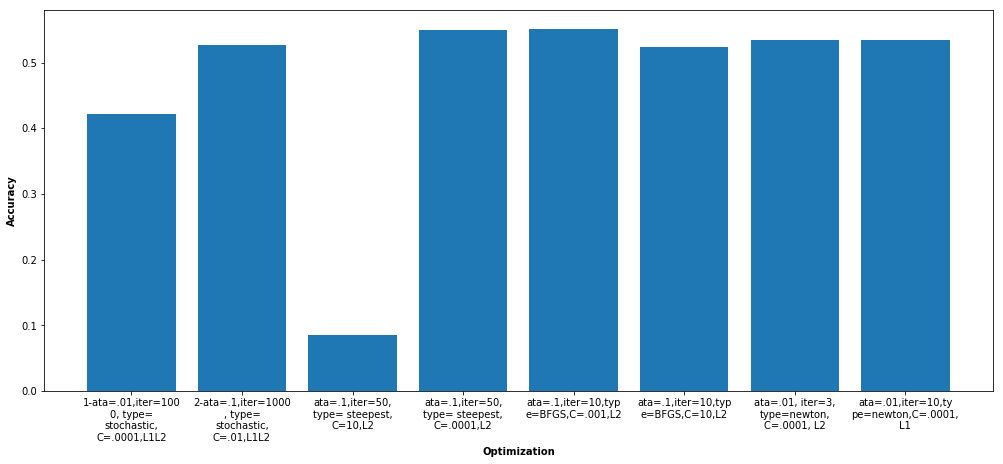

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
para=['1-ata=.01,iter=1000, type= stochastic, C=.0001,L1L2 ','2-ata=.1,iter=1000, type= stochastic, C=.01,L1L2 ','ata=.1,iter=50, type= steepest, C=10,L2 ','ata=.1,iter=50, type= steepest, C=.0001,L2 ','ata=.1,iter=10,type=BFGS,C=.001,L2','ata=.1,iter=10,type=BFGS,C=10,L2','ata=.01, iter=3, type=newton, C=.0001, L2','ata=.01,iter=10,type=newton,C=.0001,L1'  ]
acc=[stoc1,stoc2,steep,steep1,BFGS1, BFGS2,newton1,newton2]

plt.subplots(figsize=(17, 7))
x=[0,1,2,3,4,5,6,7]
z=np.polyfit(x, acc, 1)
labels = [ '\n'.join(wrap(l, 18)) for l in para ]

labels = [ '\n'.join(wrap(l, 18)) for l in para ]
plt.xlabel('Optimization', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
p = np.poly1d(z)

plt.bar(labels,acc) 

Since the time consumption for newton technique is long (over 2 minutes) and newton technique is not the best optimization technique for logistic regression, we decided not to include it in the following graph.

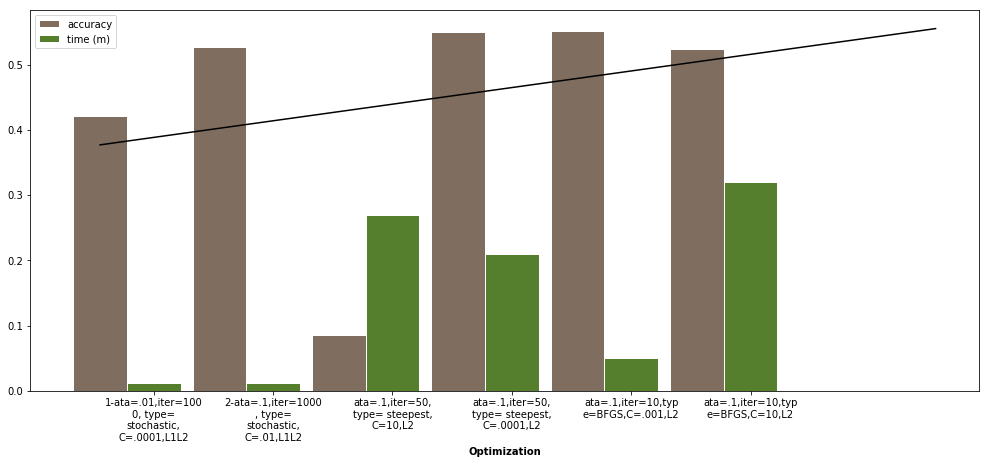

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
# set width of bar
barWidth = 0.45

# set height of bar
bars1 = [stoc1,stoc2,steep,steep1,BFGS1, BFGS2]
bars2 = [.013,.0129,.27,.21,.05,.32]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
#r3 = [x + barWidth for x in r2]
plt.subplots(figsize=(17, 7)) 
# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='accuracy')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='time (m)')

plt.plot(x,p(x),color='black')
# Add xticks on the middle of the group bars
plt.xlabel('Optimization', fontweight='bold')

plt.xticks([r + barWidth for r in range(len(bars1))], labels)
 
# Create legend & Show graphic
plt.legend()

plt.show()

### Observations:

1-the figures above shows the accuracy and time consumption for various optimization techniques, BFGS with 10 iterations has the highest accuracy with a low delay and L2 regulation.

2- stochastic has different accuracy values for different runs with the same parameters which mean the logistic regression got stuck in a local minimum depending on the initial value of the gradient and the direction 

3- steepest decent and most of the other optimization techniques returned a better accuracy for a lower C which means stronger regularization prevent from overfitting the data and in return has a better performance    

4-  BFGS did better than hessian in terms of accuracy and time consumption which means that hessian is highly computational epically in calculating the second order derivative and inverting the hessian matrix

5- the output classification had a count per classifier shown in the figure above in the data understanding section all the low count have been given the same class because there is not enough data to train a classifier 

6- the data is preprocessed such that its distribution will have a mean value 0 and standard deviation of 1. Given the distribution of the data, each value in the dataset will have the sample mean value subtracted, and then divided by the standard deviation of the whole dataset.

Based on the observations above, the best best logistic regression optimization technique is BFGS. So we will use BFGS to compare with LBFGS from sklearn. 

In [72]:
%%time
from sklearn.linear_model import LogisticRegression

lr_sk = LogisticRegression(solver='lbfgs',n_jobs=2,C=.0001, max_iter=10) 
x_train_ar=X_train.values
y_target_ar=np.asarray(y_train)
x_train_ar = StandardScaler().fit(x_train_ar).transform(x_train_ar)
lr_sk.fit(x_train_ar,y_target_ar)
print(np.hstack((lr_sk.intercept_[:,np.newaxis],lr_sk.coef_)))
yhat = lr_sk.predict(x_train_ar)
newtsk=accuracy_score(y_target_ar,yhat)
print('Accuracy of: ',accuracy_score(y_target_ar,yhat))

[[-1.84196744e+00  1.49039888e-01  1.13463874e-02 -4.12187102e-03
   8.50494284e-03 -1.36103300e-02 -4.89494661e-03 -1.87956451e-02
  -2.24026834e-02 -1.37318867e-02 -1.23513054e-02 -2.62926188e-03
  -5.18760770e-04  2.38940333e-02 -1.55745575e-03 -9.18403089e-04
  -1.17856958e-03  9.07337599e-03 -2.73376765e-03  6.72040617e-03
   2.04240348e-03 -2.62304251e-03 -2.80724425e-03  7.83106434e-03
  -4.75150469e-03  4.11670744e-03  1.12704571e-02 -3.25379392e-03
  -1.13708593e-02 -1.85296118e-03 -1.39241837e-03  5.82135287e-03
   4.16825363e-04 -2.36762190e-03  3.68362410e-03 -8.58637115e-03
  -1.86334601e-03 -2.84549026e-03 -1.68656741e-03 -1.98402432e-03
   3.43241403e-03 -3.75857571e-03 -3.82977017e-03  1.40594044e-03
   8.17483940e-03 -2.07782338e-03  3.16467373e-03 -4.61575098e-03
   9.08503036e-03  1.38607691e-02  3.67857558e-03  5.72953227e-03
  -2.73462521e-03 -1.89812110e-03 -1.14834710e-03 -1.75799907e-03
  -8.31136797e-03 -7.92720278e-03  0.00000000e+00  7.89029571e-04
   3.03008

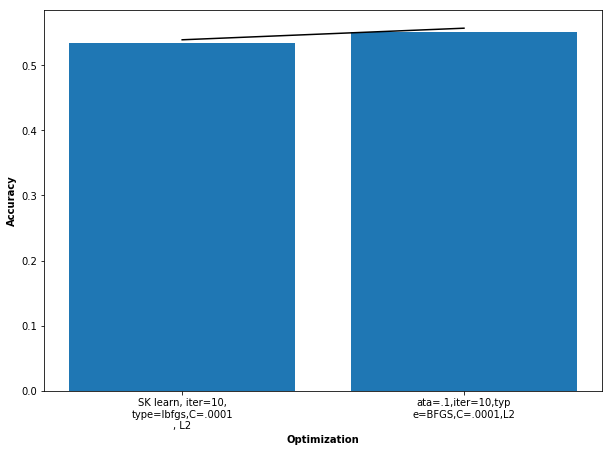

In [73]:
para=['SK learn, iter=10,type=lbfgs,C=.0001, L2','ata=.1,iter=10,type=BFGS,C=.0001,L2' ]
x=[0,1]
acc=[ newtsk,BFGS1]
time=[1.5, 1.6]
plt.subplots(figsize=(10, 7))
z=np.polyfit(x, acc, 1)
labels = [ '\n'.join(wrap(l, 18)) for l in para ]


plt.bar(labels,acc)
#ax.bar(labels,time,width=0.2,color='g')
plt.xlabel('Optimization', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
p = np.poly1d(z)
plt.plot(x,1.01*p(x),color='black')


BFGS and steepest decend optimization Techniques resulted in a better accuracy than SK learning BFGS for the same itration, as shown from the blake trend line.

In the next plot, time will be introduced.


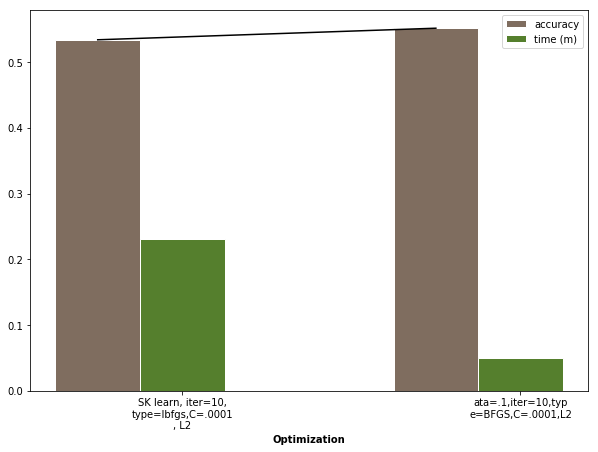

In [74]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = [newtsk, BFGS1]
bars2 = [.23,.05]
#bars3 = [29, 3, 24, 25, 17]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
#r3 = [x + barWidth for x in r2]
plt.subplots(figsize=(10, 7)) 
# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='accuracy')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='time (m)')

plt.plot(x,p(x),color='black')
# Add xticks on the middle of the group bars
plt.xlabel('Optimization', fontweight='bold')

plt.xticks([r + barWidth for r in range(len(bars1))], labels)
 
# Create legend & Show graphic
plt.legend()

plt.show()


### **3. Deployment**
------


Among all the techniques we tested above, BFGS  is the best optimization technique for logistic regression. Comparing BFGS to LBFGS from the sklearn, we see that BFGS has higher accuracy with lower time consumption (2.99s vs. 13.9s)

In our opinion,the best method to use is BFGS method since it produces the most accuracy and low time consumption.


Type Markdown and LaTeX:  𝛼2

### **4. Optimization Using Mean Squared Error**
------

In [ ]:
%%time
# from last time, our logistic regression algorithm is given by (including everything we previously had):
class BinaryLogisticRegressionForMSE:
    def __init__(self, eta, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 

blr = BinaryLogisticRegressionForMSE(eta=0.1,iterations=500,C=0.001)

x_train_ar=X_train.values
y_target_ar=np.asarray(y_train)

blr.fit(x_train_ar,y_target_ar)
print(blr)

yhat = blr.predict(x_train_ar)
print('Accuracy of: ',accuracy_score(y_target_ar,yhat))

class LineSearchLogisticRegressionWithMSE(BinaryLogisticRegressionForMSE):
    
    # define custom line search for problem
    
    @staticmethod
    def objective_function(eta,X,y,w,grad,C=0.001):
        wnew = w - grad * eta # subtract grad*eta.. from class # 02.21.19 - 10.m4v  timestamp: 23:00
        yhat = (1/(1+np.exp(-X @ wnew))) >0.5
        return np.mean((y-yhat)**2) + C*np.mean(wnew**2) # add regularization term, don't subtract.. from class  
                                                         # 02.21.19 - 10.m4v     timestamp: 17:40
    
        
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = -self._get_gradient(Xb,y)
            # minimization inopposite direction
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.iters/100} # unclear exactly what this should be
            res = minimize_scalar(self.objective_function, # objective function to optimize
                                  bounds=(self.eta/1000,self.eta*10), #bounds to optimize
                                  args=(Xb,y,self.w_,gradient,0.001), # additional argument for objective function
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            
            eta = res.x # get optimal learning rate
            self.w_ -= gradient*eta # set new function values
            # subtract to minimize

### **5. References**
------

1. Austin Animal Center Shelter Outcomes (Kaggle) https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-outcomes-and/version/1#aac_shelter_outcomes.csv
2. Austin Animal Center. (n.d.). Retrieved March 10, 2019, from http://www.austintexas.gov/department/aac
3. Hawes, Sloane; Ikizler, Devrim; Loughney, Katy; Tedeschi, Philip; and Morris, Kevin, "Legislating Components of a Humane City: The Economic Impacts of the Austin, Texas "No Kill" Resolution (City of Austin Resolution 20091105-040)" (2017). Animal Law and Legislation. 1. 
https://animalstudiesrepository.org/anilleg/1